# Improving the home hunting process by identifying one's ideal living area

### This project uses clustering and keyword-based filtering to identify the most suitable area for property search based one's specific criteria

#### Retrieving the appropriate dataset and generating a dataframe

In [1]:
import pandas as pd 

In [2]:
dataset = pd.read_html('https://www.finder.com/uk/london-crime-statistics')

In [3]:
df_London = pd.DataFrame(dataset[1])
df_London

,Borough Name,Crime count
0,Westminster,71034
1,Wandsworth,27841
2,Waltham Forest,25656
3,Tower Hamlets,36275
4,Sutton,13272
5,Southwark,38862
6,Richmond upon Thames,13704
7,Redbridge,25308
8,Newham,38654
9,Merton,14885


#### The dataset is clean, but we can express the crime as % of total rather than overall number to compare the boroughs

In [7]:
# change crime count to crime rate (perc. of total)

df_London.rename(columns ={"Crime count":"Crime rate"}, inplace = True)
df_London['Crime rate'] = round(df_London['Crime rate']/df_London['Crime rate'].sum()*100,2)

df_London.head()


,Borough Name,Crime rate,Latitude,Longitude,Distance
0,Westminster,7.74,51.501356,-0.124930,2.43
1,Wandsworth,3.03,51.457027,-0.193261,8.00
2,Waltham Forest,2.79,51.598169,-0.017837,12.09
3,Tower Hamlets,3.95,51.525629,-0.033585,7.44
4,Sutton,1.45,51.357511,-0.173640,18.33


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

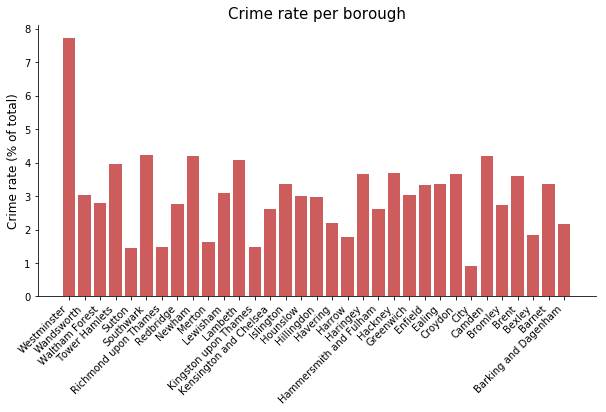

In [9]:
# plot distribution of crime rate across boroughs

plt.figure(figsize = (10,5))

x = df_London['Borough Name']
y = df_London['Crime rate']

plt.ylabel('Crime rate (% of total)', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.title('Crime rate per borough', fontsize = 15)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.bar(x,y,color='indianred')

plt.show()



#### Now we can retrieve the coordinates for each borough
##### Additionally, we compute the distance from a random target location (eg workplace), to be later used as an additional filtering criterion

In [4]:
import geopy
from geopy import Nominatim
from geopy.distance import distance

In [5]:

geo_locator = Nominatim(user_agent="my-application")
target = [51.5209234,-0.140507]
lat = []
lng = []
dist = []
for i in range(len(df_London)):
    location = geo_locator.geocode(df_London['Borough Name'][i]+', London, United Kingdom')
    lat.append(location.latitude)
    lng.append(location.longitude)
    dist.append(distance(target, [location.latitude, location.longitude]).m)
    
df_London['Latitude'] = lat
df_London['Longitude'] = lng
df_London['Distance'] = dist
 
df_London['Distance'] = round(df_London['Distance']/1000,2) #converts distance to km

df_London.head()

#### We can now use Foursquare to obtain the venue information for each of the boroughs

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
# Get the venue data

import json
import requests
from pandas.io.json import json_normalize

CLIENT_ID = '52N0QP5ME4N5VLLIJPGPB4JXVNW3J2FEOTLMPWL5Y3LFYD2J' 
CLIENT_SECRET = 'KGA0SNI0DESCREVQ0SIKAGR32E4KXXMZWM3LPEVRUMEP5QXA' 
VERSION = '20180605'

LIMIT = 100
RADIUS = 2000 #metres, adjusted for smaller boroughs

# Create new data frame for venues

London_venues = pd.DataFrame(columns=['Borough','Borough Latitude','Borough Longitude',
                          'Venue','Venue Latitude','Venue Longitude','Venue category'])

#Now loop over the neighborhoods and extract venue info for each of them

for i in range(len(df_London)):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        df_London['Latitude'][i],
        df_London['Longitude'][i],
        RADIUS, 
        LIMIT)

    results = requests.get(url).json()
    
    # get the venue info
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    
    for ii in range(len(nearby_venues)):
        London_venues = London_venues.append({'Borough':df_London['Borough Name'][i],
                             'Borough Latitude':df_London['Latitude'][i],
                             'Borough Longitude':df_London['Longitude'][i],
                             'Venue':nearby_venues['name'][ii],
                             'Venue Latitude':nearby_venues['lat'][ii],
                             'Venue Longitude':nearby_venues['lng'][ii],
                             'Venue category':nearby_venues['categories'][ii]}, ignore_index = True)
    
London_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue category
0,Westminster,51.501356,-0.12493,Elizabeth Tower (Big Ben) (Big Ben (Elizabeth ...,51.500620,-0.124578,Monument / Landmark
1,Westminster,51.501356,-0.12493,Parliament Square,51.500595,-0.126802,Plaza
2,Westminster,51.501356,-0.12493,The London Eye,51.503287,-0.119594,Scenic Lookout
3,Westminster,51.501356,-0.12493,Horse Guards Parade,51.504847,-0.126590,Plaza
4,Westminster,51.501356,-0.12493,St James's Park,51.503253,-0.132995,Park


In [13]:
# one-hot encoding of venue categories
London_onehot = pd.get_dummies(London_venues[['Venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Borough'] = London_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

,Borough,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Westminster,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Westminster,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Westminster,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Westminster,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Westminster,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### We can visualise the total number of venues found in each borough...

In [15]:
tot_venues = London_onehot.groupby('Borough').sum().sum(axis=1)
df_London['Total venues'] = ""
for i in range(len(tot_venues)):
    df_London['Total venues'][i] = tot_venues[i]

df_London.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Borough Name,Crime rate,Latitude,Longitude,Distance,Total venues
0,Westminster,7.74,51.501356,-0.124930,2.43,29
1,Wandsworth,3.03,51.457027,-0.193261,8.00,41
2,Waltham Forest,2.79,51.598169,-0.017837,12.09,61
3,Tower Hamlets,3.95,51.525629,-0.033585,7.44,100
4,Sutton,1.45,51.357511,-0.173640,18.33,63


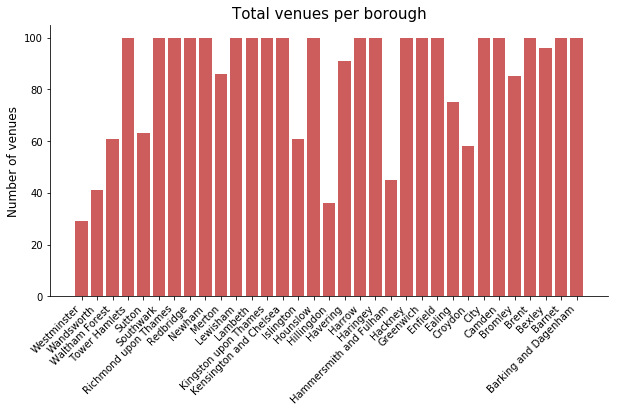

In [16]:
# how do different boroughs compare in number of venues
plt.figure(figsize = (10,5))

x = df_London['Borough Name']
y = df_London['Total venues']

plt.ylabel('Number of venues', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.title('Total venues per borough', fontsize = 15)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.bar(x,y,color='indianred')

plt.show()

#### ...and the number of unique venue categories

In [17]:
London_grouped = London_onehot.groupby('Borough').mean().reset_index()
London_grouped.head()

,Borough,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Barnet,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bexley,0.0,0.032787,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.016393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brent,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bromley,0.0,0.015873,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


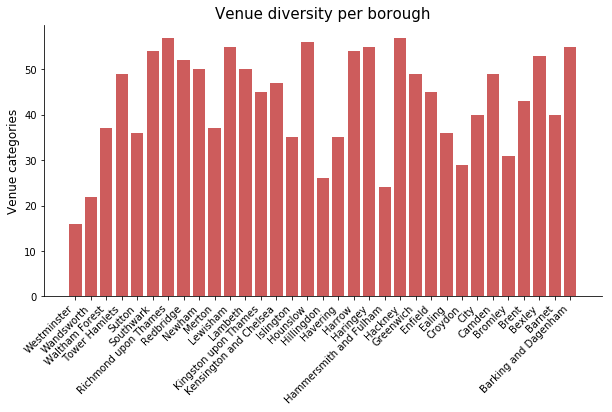

In [18]:
# how diverse are the venues in each borough - can represent as number of non-0 categories

num_cat = London_grouped.isin({0.0}).sum(1)

plt.figure(figsize = (10,5))

x = df_London['Borough Name']
y = 257-num_cat

plt.ylabel('Venue categories', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.title('Venue diversity per borough', fontsize = 15)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.bar(x,y,color='indianred')

plt.show()

#### Next, we attempt grouping the boroughs into distinct clusters based on the venue information and crime rate

In [19]:
import sklearn 
from sklearn.cluster import KMeans


London_clustering = London_grouped.drop('Borough', 1)
London_clustering['Crime rate'] = df_London['Crime rate']
wcss = []

# find the elbow point based on within-cluster sum of squares (wcss)
for kclusters in range(1, 11):

    kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=500, n_init=50, random_state=0).fit(London_clustering)
    wcss.append(kmeans.inertia_)
    
  


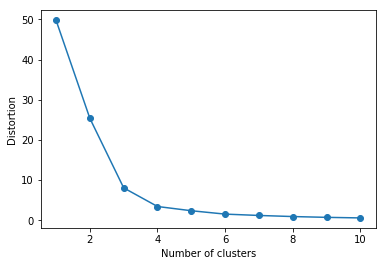

In [20]:
plt.plot(range(1, 11), wcss[0:10], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.show()

In [21]:
# There's a beautiful elbow point at k=4 
kclusters = 4
kmeans = KMeans(kclusters, init='k-means++', max_iter=500, n_init=50, random_state=0).fit(London_clustering)

In [22]:
# add clustering labels
df_London['Cluster Labels']= kmeans.labels_

df_London.head() 

,Borough Name,Crime rate,Latitude,Longitude,Distance,Total venues,Cluster Labels
0,Westminster,7.74,51.501356,-0.124930,2.43,29,0
1,Wandsworth,3.03,51.457027,-0.193261,8.00,41,1
2,Waltham Forest,2.79,51.598169,-0.017837,12.09,61,1
3,Tower Hamlets,3.95,51.525629,-0.033585,7.44,100,3
4,Sutton,1.45,51.357511,-0.173640,18.33,63,2


#### Let's explore the clusters

In [23]:
!conda install -c conda-forge folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

In [24]:
# Quickly visualise our clusters
import folium

kclusters=4
London_location = [51.501356, -0.124930]

# create map
map_clusters = folium.Map(location=London_location, zoom_start=11)

# set color scheme for the clusters
rainbow = ['aquamarine','salmon', 'thistle', 'powderblue']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_London['Latitude'], df_London['Longitude'], df_London['Borough Name'], df_London['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
folium.TileLayer('stamenterrain').add_to(map_clusters)
       
map_clusters


In [ ]:
!conda install -c conda-forge wordcloud

In [25]:
# Is each cluster characterised by distinctive features? 
# Generate wordclouds from all the venues in each cluster to visualise which venues are most frequent
from wordcloud import WordCloud

all_venues = London_venues.groupby('Borough')

for n in range(len(grouped.groups)):
    cluster_x = df_London['Borough Name'][(grouped.groups[n])]
    text = []

    for borough in cluster_x:
        text.append(London_venues['Venue category'][all_venues.groups[borough]].tolist())

# Create and generate a word cloud image:
    textxt = "-".join(text[0])
          
    wcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(textxt) 
    
# Display the generated image:
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.title('Cluster %d' %(n), fontsize = 15)
    plt.show()
    
    



,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,Grocery Store,Pub,Pub,Coffee Shop,Pub,Pub,Hotel,Pub,Pub,Pub,...,Park,Grocery Store,Pizza Place,Pub,Hotel,Grocery Store,Pub,Pub,Pub,Theater
1,Supermarket,Coffee Shop,Coffee Shop,Sandwich Place,Pizza Place,Park,Coffee Shop,Coffee Shop,Coffee Shop,Supermarket,...,Pub,Pub,Pub,Café,Theater,Pub,Coffee Shop,Grocery Store,Coffee Shop,Hotel
2,Gas Station,Grocery Store,Clothing Store,Grocery Store,Clothing Store,Coffee Shop,Gym / Fitness Center,Clothing Store,Park,Coffee Shop,...,Supermarket,Fast Food Restaurant,Park,Italian Restaurant,Coffee Shop,Coffee Shop,Café,Turkish Restaurant,Park,Plaza
3,Bus Stop,Golf Course,Italian Restaurant,Clothing Store,Park,Café,Cocktail Bar,Park,Italian Restaurant,Pizza Place,...,Grocery Store,Sandwich Place,Grocery Store,Park,Pub,Clothing Store,Canal Lock,Supermarket,Café,Garden
4,Pub,Café,Supermarket,Hotel,Gym / Fitness Center,Market,Scenic Lookout,Supermarket,Hotel,Grocery Store,...,Coffee Shop,Park,English Restaurant,Garden,Scenic Lookout,Italian Restaurant,Park,Coffee Shop,Pizza Place,Park


#### Next step: defining and applying additional filters

In [26]:
# define the keywordsto be used for filtering and count how many times they occur in each borough's list of venues

desired_venues = ['Park', 'Lake', 'Market', 'Gym', 'Organic Grocery', 'Garden', 'Bakery']

all_venues = London_venues.groupby('Borough')
tot_score = []
for borough in df_London['Borough Name']:
    score = 0
    for cat in desired_venues:
        score = score + London_venues['Venue category'][all_venues.groups[borough]].str.contains(cat).sum()
    tot_score.append(score)

df_London['Match score'] = tot_score

df_London.head()

,Borough Name,Crime rate,Latitude,Longitude,Distance,Total venues,Cluster Labels,Match score
0,Westminster,7.74,51.501356,-0.124930,2.43,29,0,3
1,Wandsworth,3.03,51.457027,-0.193261,8.00,41,1,3
2,Waltham Forest,2.79,51.598169,-0.017837,12.09,61,1,2
3,Tower Hamlets,3.95,51.525629,-0.033585,7.44,100,3,7
4,Sutton,1.45,51.357511,-0.173640,18.33,63,2,7


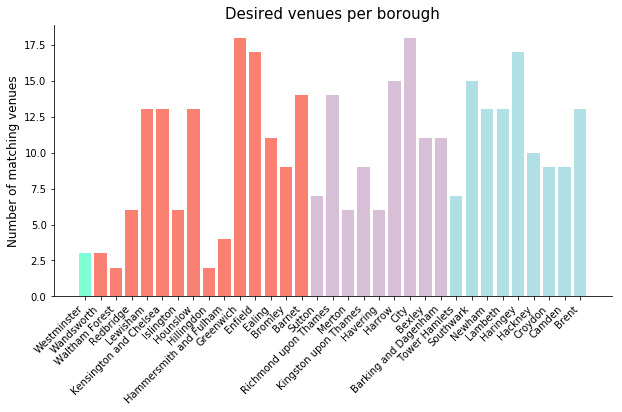

In [27]:

grouped = df_London.groupby('Cluster Labels')

plt.figure(figsize = (10,5))

plt.ylabel('Number of matching venues', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.title('Desired venues per borough', fontsize = 15)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

for n in range(len(grouped.groups)):
    cluster_x = df_London['Borough Name'][(grouped.groups[n])]
    plt.bar(cluster_x,df_London['Match score'][(grouped.groups[n])],color = rainbow[n])


plt.show()

In [ ]:
# I get a couple of clusters that seem like good options, is crime rate a determinant feature for the clusters?

cluster_df = df_London.groupby('Cluster Labels').median()
cluster_df

In [ ]:
grouped = df_London.groupby('Cluster Labels')

plt.figure(figsize=(3,5))
plt.ylabel('Match score', fontsize=12)
plt.xlabel('Crime rate', fontsize=12)
plt.title('Match vs Crime', fontsize = 15)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

for n in range(len(grouped.groups)):
    cluster_x = df_London['Borough Name'][(grouped.groups[n])]
    plt.scatter(df_London['Crime rate'][(grouped.groups[n])],df_London['Match score'][(grouped.groups[n])],c = rainbow[n])
    
plt.show()

#### Putting it all together

In [ ]:
#Displaying each borough colour-coded by the cluster it belongs to and with a marker diameter corresponding to its match score.
#The large blue circle provides a 10 km radius boundary around the target location

radius_limit = 10000 #10 km, coresponding to a 40-45 minute commute

# create map
map_clusters = folium.Map(location=target, zoom_start=11)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, match in zip(df_London['Latitude'], df_London['Longitude'], df_London['Borough Name'], df_London['Cluster Labels'], df_London['Match score']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2+match/1.5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

folium.Circle(target,radius=radius_limit).add_to(map_clusters)
folium.TileLayer('stamenterrain').add_to(map_clusters)
       
map_clusters